# Sprint10課題 深層学習スクラッチニューラルネットワーク


## 1.この課題の目的

- スクラッチを通してニューラルネットワークの基礎を理解する
- 画像データの簡単な扱い方を知る

## 2.スクラッチによる実装

NumPyなど最低限のライブラリのみを使いアルゴリズムを実装する。

今回は多クラス分類を行う3層のニューラルネットワークを作成する。

層の数などは固定した上でニューラルネットワークの基本を確認する。

次のSprintで層を自由に変えられる設計とする。

In [1]:
# 演算
import numpy as np
import pandas as pd

# 可視化
import matplotlib.pyplot as plt
import seaborn as sns

# 機械学習
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc

# データセットの準備
from keras.datasets import mnist

# 表示
import pprint

%matplotlib inline

Using TensorFlow backend.


### データセットの用意
MNISTデータセットを使用する。

以下のコードを実行すれば、Kerasによりデータセットをダウンロード、展開が行われる。

In [2]:
# データを格納
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
value = np.unique(y_test)
value

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

### MNISTとは？

- 画像分類のための定番データセットで、手書き数字認識を行う。

- このデータセットには学習用6万枚、テスト用1万枚の28×28ピクセルの白黒画像、およびそれらが0〜9のどの数字であるかが含まれている。

### 画像データとは？

- デジタル画像は点の集合で、これをピクセルと呼ぶ。
- 一般的に白黒画像であればピクセルには0〜255の値が含まれる。
- 一方、カラー画像であればR（赤）、G（緑）、B（青）それぞれに対応する0〜255の値が含まれる。
- 機械学習をする上では、この0〜255の値一つひとつが特徴量として扱われる。
- 0〜255は符号なしの8ビット整数で表せる範囲になるため、NumPyであれば「uint8」型の変数として保持できる。

In [4]:
# データセットの確認
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
print(X_train[0].shape) # (28, 28)
#print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8
(28, 28)


## 3.平滑化

- (1, 28, 28)の各画像を、(1, 784)に変換する。

- これまで学んできた機械学習手法や、今回扱う全結合層のみのニューラルネットワークではこの形で扱う。

- 全てのピクセルが一列になっていることを、<font color = "Blue">**平滑化（flatten）**</font>と表現する。

In [5]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

### 補足

- ここまで機械学習を学んでくる中で、特徴量の数を**「次元」**と呼んできた。
- その視点では、MNISTは784次元（＝28 * 28）のデータとなる。
- 一方、NumPyのshapeが(784,)の状態を1次元配列とも呼びます。

- 画像としての縦横の情報を持つ（28, 28)の状態であれば、2次元配列です。
- この視点では2次元のデータであり、もしもカラー画像であれば(28, 28, 3)ということになり、3次元配列となる。
- 先ほどの視点では3次元のデータとなる。

- しかし、白黒でもカラーでも平面画像であり、立体データではないという視点で、2次元のデータである。
- 画像データを扱う際にはこのように「次元」という言葉が複数の意味合いで使われることに注意すること。

In [6]:
print(X_train.shape) # (60000, 784)
print(X_test.shape) # (10000, 784)

(60000, 784)
(10000, 784)


### 画像データの可視化
画像データを可視化する。plt.imshowに渡す。

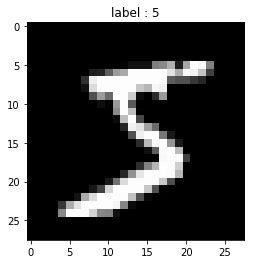

In [7]:
%matplotlib inline

index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray', vmin = 0, vmax = 255)
plt.title('label : {}'.format(y_train[index]))
plt.show()

### 前処理

- 画像は0から255のuint8型で表されるが、機械学習をする上では0から1のfloat型で扱うことになる。
- 色は理想的には連続値であり、それを特徴量とするためである。（以下のコードで変換可能）

In [8]:
# 最大値、最小値の確認

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [9]:
# 学習用データ、検証用データの生成
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)
print(X_train.shape)
print(X_val.shape)

(48000, 784)
(12000, 784)


### One-Hot Encoding

In [10]:
enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis]) # 学習用データ
y_test_one_hot = enc.transform(y_test[:, np.newaxis]) # テストデータ

print(y_train.shape)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(48000,)
(48000, 10)
float64


- 正解ラベルは0から9の整数だが、ニューラルネットワークで多クラス分類を行う際にはone-hot表現に変換します。
- scikit-learnのOneHotEncoderを使用して変換できる。（one-hot表現による値はそのラベルである確率を示していることになるため、float型で扱う）

In [11]:
y_train_one_hot.shape

(48000, 10)

- さらに、学習用データ6万枚の内2割を検証用データとして分割すること。
- 学習用データが48000枚、検証用データが12000枚となる。

### 【問題1】ニューラルネットワーク分類器のクラスを作成

ニューラルネットワーク分類器のクラスScratchSimpleNeuralNetrowkClassifierを作成する。

### フォワードプロパゲーション

- 三層のニューラルネットワークのフォワードプロパゲーションを作成する。
- 以下の説明ではノード数は1層目は400、2層目は200としますが、変更しても構わない。

### 重みの初期値

- ニューラルネットワークにおいて、重みの初期値は重要な要素である。
- 様々な方法が提案されているが、今回はガウス分布による単純な初期化を行う（バイアスに関しても同様）。

### クラスの作成

In [69]:
# 演算処理
import numpy as np

# 可視化
import matplotlib.pyplot as plt

# 機械学習
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

# 時間計測
from tqdm import tqdm_notebook as tqdm
import time

class ScratchSimpleNeuralNetworkClassifier:
    """
    ニューラルネットワークのスクラッチ実装
    
    Parameters
    ----------
    lr : float (default : 0.01)
        学習率
    
    batch : int
        バッチサイズ
        
    epoch : int
        epoch
    
    n_nodes1 : int
        １層目のノード数
        
    n_nodes2 : int
        2層目のノード数   
    
    func : str
        活性化関数("sigmoid" or "tanh")
    
    random_state_batch : int
        乱数（ミニバッチ）生成のシード値
    
    random_state_para : int
        乱数（パラメータ初期値）生成のシード値
    
    
    Attributes
    ----------
    self.w : 次の形のndarray, shape
        重み
        
    self.b : 次の形のndarray, shape
        バイアス
    
    self.loss : float
        交差エントロピー誤差
    
    """
    
    def __init__(self, lr=0.01, batch_size=10, activation_f="tanh", epoch=10, n_nodes1=400, n_nodes2=200,
                 n_output = 10, random_state_batch=1, random_state_para=1, sigma=0.01, verbose=False):
        
        # パラメータ
        self.activation_f = activation_f # 活性化関数の種類
        self.batch = batch_size # バッチサイズ
        self.epoch = epoch # バッチあたりの学習回数
        self.label = None # 正解ラベル
        self.lr = lr # 学習率
        self.n_nodes1 = n_nodes1 # 1層目のノード数
        self.n_nodes2 = n_nodes2 # 2層目のノード数
        self.n_output = None # 出力のクラス数（3層目のノード数）
        self.random_state_batch  = random_state_batch # ランダムなミニバッチ生成時のシード値
        self.random_state_para = random_state_para # パラメータ初期値をランダムに生成する際のシード値
        self.sigma = sigma # 正規分布の標準偏差
        
        # 重み
        self.w1 = None # 第1層
        self.w2 = None # 第２層
        self.w3 = None # 第３層
        
        # バイアス
        self.b1 = None # 第１層
        self.b2 = None # 第２層
        self.b3 = None # 第３層
        
        # 交差エントロピー誤差
        self.train_loss = [] # 学習用データに基づく損失
        self.val_loss = [] # 検証用データに基づく損失
        
        # 予測精度
        self.accuracy_train = []
        self.accuracy_val = []
        
        # 活性化関数の入力
        self.a1 = 0 # 1層目
        self.a2 = 0 # 2層目
        self.a3 = 0 # 3層目
        
        # 活性化関数の出力
        self.z1 = 0 # 1層目
        self.z2 = 0 # 2層目
        self.z3 = 0 # 3層目
    
        # 学習過程の出力
        self.verbose = verbose
        
    
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する
        
        Parameters
        ----------
        X_train : 次の形のndarray, shape(batch_size, n_features)
            学習用データ（特徴量）
        
        y_train : 次の形のndarray, shape(batch_size, n_output)
            学習用データ（正解ラベル）
        
        """
        # 正解ラベル
        self.label = np.unique(y_train)
        self.n_output  = len(np.unique(y_train)) # 個数        
        
        # One-Hot Encoding
        enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
        y_train = enc.fit_transform(y_train[:, np.newaxis]) # 学習用データ
        if y_val is not None:
            y_val = enc.fit_transform(y_val[:, np.newaxis]) # 検証用データ
        
        np.random.seed(self.random_state_para)
        
        # 重みの初期値
        self.w1 = self.sigma * np.random.randn(X_train.shape[1] * self.n_nodes1).reshape(X_train.shape[1], self.n_nodes1)
        self.w2 = self.sigma * np.random.randn(self.n_nodes1 * self.n_nodes2).reshape(self.n_nodes1, self.n_nodes2)
        self.w3 = self.sigma * np.random.randn(self.n_nodes2 * self.n_output).reshape(self.n_nodes2, self.n_output)

        # バイアスの初期値 
        self.b1 = self.sigma * np.random.randn(self.n_nodes1) # 1層目
        self.b2 = self.sigma * np.random.randn(self.n_nodes2) # 2層目
        self.b3 = self.sigma * np.random.randn(self.n_output) # 3層目
        
        # 学習
        for i in tqdm(range(self.epoch)):
            get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=self.batch, seed=self.random_state_batch)
            
            for mini_X_train, mini_y_train in tqdm(get_mini_batch):
            
                # 学習用データ
                z_train = self._forward_propagation(mini_X_train)# フォワードプロパゲーション
                y_pred_train = np.argmax(z_train, axis=1)
                self._back_propagation(mini_X_train, z_train, mini_y_train) #バックプロパゲーション
                
                # 損失、予測精度を計算する
                train_loss = self._cross_entropy_error(z_train, mini_y_train) / self.batch
                accuracy_train = accuracy_score(np.where(mini_y_train == 1)[1], y_pred_train)
                self.train_loss.append(train_loss)
                self.accuracy_train.append(accuracy_train)
                
                # 学習過程を表示する
                if self.verbose == True:
                    print("train_loss : {}".format(train_loss))

                
                # 検証用データがある場合、交差エントロピー誤差を算出する
                if (X_val is not None) and (y_val is not None):
                    z_val = self._forward_propagation(X_val)
                    y_pred_val = np.argmax(z_val, axis=1)
                    
                    # 損失、予測精度を計算する
                    val_loss = self._cross_entropy_error(z_val, y_val) / len(z_val)
                    accuracy_val = accuracy_score(np.where(y_val == 1)[1], y_pred_val)
                    self.val_loss.append(val_loss)
                    self.accuracy_val.append(accuracy_val)

                    # 学習過程を表示する
                    if self.verbose == True:
                        print("val_loss : {}".format(val_loss))
            

                    
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。
        
        Parameters
        -----------
        X : 次の形のndarray, shape(m_samples, n_features)
            テストデータ（特徴量）
        
        
        Returns
        ---------
        y_pred : 次の形のndarray, shape(m_sample, 1)
            推定結果
        
        """
        # フォワードプロパゲーション（確率ベクトルの算出）
        z = self._forward_propagation(X)
        
        # 最も確率の高いラベルを取得する
        y_pred = np.argmax(z, axis=1)
                
        return y_pred
    
    
    
    def _forward_propagation(self, X):
        """
        フォワードプロパゲーション
        
        Paramerters
        ---------
        X : 次の形のndarray, shape(m_samples, n_features)
            特徴量
            
        Returns
        ---------
        z3 : 次の形のndarray, shape(m_samples, n_nodes)
            3層目の出力
        
        """

        # 第１層
        a1 = np.dot(X, self.w1) + self.b1 # 各ノードの出力（活性化前）
        z1 = self._activation_function(a1) # 出力（2層目の入力）
        
        self.a1 = a1
        self.z1 = z1

        
        # 第２層
        a2 = np.dot(z1, self.w2) + self.b2 # 各ノードの出力（活性化前）
        z2 = self._activation_function(a2) # 出力：3層目の入力（m_samples, n_nodes2)
        
        self.a2 = a2
        self.z2 = z2
        
        
        # 第３層
        a3 = np.dot(z2, self.w3) + self.b3 # 各ノードの出力（活性化前）
        z3 = self._softmax(a3) # 出力：確率ベクトル(m_samples, n_output)
        
        self.a3 = a3
        self.z3 = z3
        
        return z3
    
    
    def _back_propagation(self, X, z, y):
        """
        バックプロパゲーション
        
        Parameters
        ----------
        X : 次の形のndarray, shape(batch_size, n_features)
            学習用データ（特徴量）
        
        z : 次の形のndarray, shape(batch_size, n_output)
            確率ベクトル
            
        y : 次の形のndarray, shape(batch_size, n_output)
            正解ラベル
        
        """
        
        # 第３層のパラメータ更新
        grad3 = z - y # 勾配
        self.b3 = self.b3 - self.lr * np.mean(grad3, axis=0) # バイアスの更新        
        self.w3 = self.w3 - self.lr * np.dot(self.z2.T, grad3)/self.batch # 重みの更新

        
        # 第２層のパラメータ更新
        grad2 = np.dot(grad3, self.w3.T) * self._activation_function_diff(self.a2) # 勾配        
        self.b2 =  self.b2 - self.lr * np.mean(grad2, axis=0) # バイアスの更新
        self.w2 = self.w2 - self.lr * np.dot(self.z1.T, grad2)/self.batch # 重みの更新
        
        
        # 第1層のパラメータ更新
        grad1 = np.dot(grad2, self.w2.T) * self._activation_function_diff(self.a1) # 勾配
        self.b1 =  self.b1 - self.lr * np.mean(grad1, axis=0) # バイアス
        self.w1 = self.w1 - self.lr * np.dot(X.T, grad1)/self.batch # 重み
        
    
    def _sigmoid(self, x):
        """
        シグモイド関数
        
        Parameters
        ---------
        x : 次の形のndarray, shape(m_samples, n_features)
            特徴量

        Returns
        ---------
        z : 次の形のndarray, shape(m_samples, n_features)
            確率
        """
        
        z = 1 / (1 + np.exp(-x))
        
        return z
    
    
    def _activation_function(self, x):
        """
        活性化関数
        
        Parameters
        ---------
        X : 次の形のndarray, shape(m_samples, n_features)
            特徴量
        
        Returns
        ---------
        z : 次の形のndarray, shape(m_samples, n_features)
            確率
        
        """
        try:
            if self.activation_f == "tanh":
                return np.tanh(x)
            elif self.activation_f == "sigmoid":
                return self._sigmoid(x)
        except ValueError:
            print("'ValueError! : Activation function type are 'sigmoid' or 'tanh.'")
    
    
    def _activation_function_diff(self, x):
        """
        シグモイド関数
        
        Parameters
        ---------
        x : 次の形のndarray, shape(m_samples, n_features)
            特徴量
            
        
        Returns
        ---------
        z : 次の形のndarray, shape(m_samples, n_features)
            確率
        
        """
        if self.activation_f == "tanh":
            return 1- np.tanh(x)**2
        elif self.activation_f == "sigmoid":
            return (1- self.sigmoid(x)) * self.sigmoid(x)
    

    
    def _softmax(self, x):
        """
        ソフトマックス関数
        
        Parameters
        ----------
        x : 次の形のndarray, shape(m_samples, n_nodes2)
            出力（想定：第２層の出力／第３層の入力）
        
        
        Returns
        ----------
        z : 次の形の出力（m_samples, n_output）
            予測確率（第３層の出力）
        
        """
        
        z = np.exp(x) / np.sum(np.exp(x), axis = 1).reshape(-1, 1)        
        
        return z
    
    
    def _cross_entropy_error(self, z, y):
        """
        交差エントロピー誤差

        Parameters
        ---------
        z : 次の形のndarray, shape()
            出力値（想定：第３層の出力）
        
        y : 次の形のndarray, shape(m_samples, n_output)
            正解値
        
        """
        
        return - np.sum(y * np.log(z))
        
    
    def show_learning_curve(self, ):
        """
        学習曲線を描画する
        
        """
        iteration = np.arange(len(self.train_loss))
        train_loss = self.train_loss
        val_loss = self.val_loss
        
        accuracy_train = self.accuracy_train
        accuracy_val = self.accuracy_val
        
        FIG_SIZE = (12,4)
        fig = plt.figure(figsize=FIG_SIZE)
        
        plt.style.use("seaborn-whitegrid")
        
        # 損失の推移を描画
        plt.subplot(1,2,1)
        plt.plot(iteration, train_loss, label = "average_train_loss", color="b")
        if val_loss is not []:
            plt.plot(iteration, val_loss, label="average_val_loss", color="r")
        plt.xlabel("epoch * iteration")
        plt.ylabel("average_cross_entropy_loss")
        plt.title("Learning Curve : value of cost function")
        plt.legend(loc="best")
        
        # 予測精度を描画
        plt.subplot(1,2,2)
        plt.plot(iteration, accuracy_train, label = "accuracy_train", color="b")
        if accuracy_val is not []:
            plt.plot(iteration, accuracy_val, label="accuracy_val", color="r")
        plt.xlabel("epoch * iteration")
        plt.ylabel("accuracy")
        plt.title("Learning Curve : accuracy")
        plt.legend(loc="best")
        
        # グラフ表示
        plt.tight_layout()
        plt.show()
        
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
      
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    
    batch_size : int
      バッチサイズ
    
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

### 検証

In [74]:
# インスタンス生成(Multi-layer Perceptron classifier)
clf = ScratchSimpleNeuralNetworkClassifier(batch_size=30, epoch=5, n_nodes1=400, n_nodes2=200, verbose=False)

In [75]:
# 学習
clf.fit(X_train, y_train, X_val, y_val)
%time

CPU times: user 30 µs, sys: 0 ns, total: 30 µs
Wall time: 11.9 µs


### 【問題2】学習曲線のプロット

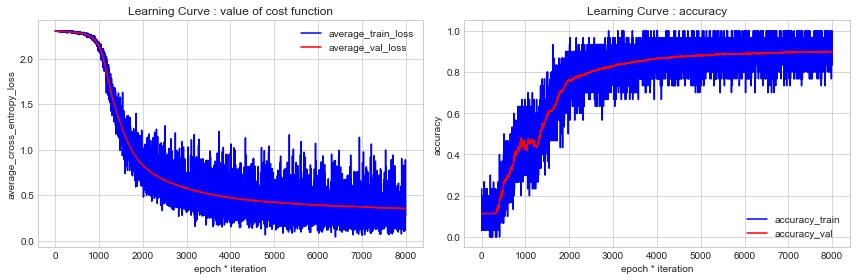

In [76]:
# 学習曲線
clf.show_learning_curve()

- epochを重ねるごとに損失（交差エントロピー誤差）が減少しており、学習が進んでいる様子を確認できる。
- 検証用データによる交差エントロピー誤差も漸減し、またaccuracyも漸増していることから、過剰適合は生じていないことが確認された。

### 【問題3】指標値の算出

分類に関する指標値で精度を確認する。

In [79]:
# 検証用データの特徴量に基づく予測
y_pred = clf.predict(X_test)

# パラメータ
average="micro"
index = ["accuracy", "precision", "recall", "f1"]

# 評価指標を算出
accuracy = np.round(accuracy_score(y_test, y_pred), 2)
precision = np.round(precision_score(y_test, y_pred, average=average), 2)
recall = np.round(recall_score(y_test, y_pred, average=average), 2)
f1 = np.round(f1_score(y_test, y_pred, average=average), 2)

# 出力
df = pd.DataFrame([accuracy, precision, recall, f1], index=index, columns=["score"])
df

,score
accuracy,0.91
precision,0.91
recall,0.91
f1,0.91


### （オプション）誤分類の確認

- 誤分類した画像はどのようなものだったかを見てみる。
- 推定値を用意し、以下のコードを実行する。

/Users/makintosh/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app


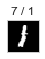

In [80]:
"""
誤分類結果を並べて表示する。画像の上の表示は「推定結果/正解」である。

Parameters:
----------
y_pred : 推定値のndarray (n_samples,)
y_val : 検証用データの正解ラベル(n_samples,)
X_val : 検証用データの特徴量（n_samples, n_features)
"""
import numpy as np
import matplotlib.pyplot as plt

num = 36 # いくつ表示するか

true_false = y_pred==y_val
false_list = np.where(true_false==False)[0].astype(np.int)

if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(y_pred[false_list[i]],y_val[false_list[i]]))
    ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')

### 正解率

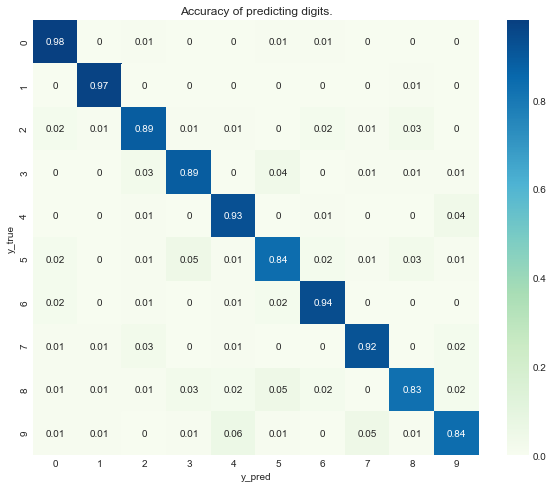

In [83]:
# カウント
true_false  = np.zeros(100).reshape(10,10)

# 正解ラベル、予測値の正誤表を作成
for i in range(len(y_test)):
    true = y_test[i]
    pred = y_pred[i]
    
    true_false[true][pred] += 1

# パーセンテージ換算
true_false = np.round(true_false / np.sum(true_false, axis=1), 2)

# 可視化
plt.figure(figsize=(10, 8))
sns.heatmap(true_false, annot=True, cmap="GnBu")
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title("Accuracy of predicting digits.")
plt.show()

- 予測の結果、正解率はいずれの数値も80%を超える結果となった。

- 数値毎の正解率に偏りがみられるが、エポック数を増やし、学習を進めることで全体的に正解率が向上すると思われる。

### 本課題からの学び

1. スクラッチ実装を通じて、ニューラルネットワークの要点を理解することができた。
    - パラメータの初期値：
        - レイヤー、ノードの数：何層にするか？
        - 初期値はランダムに設定する（同じ値で初期化すると精度が上がらなかった）
    - 順伝播、逆伝播：
        - 連鎖律（和、積の違い）を理解する。
        - 逆伝播においては平均誤差（誤差をバッチサイズで除した値）を用いることで、推計されるパラメータが不偏推定量（学習曲線の振幅が抑えられる）になる。
    - 損失関数：回帰の場合は交差エントロピー誤差。ニューラルネットワークでは回帰も可能。その場合は平均二乗誤差を用いるのが良さそう。）
    - ミニバッチ処理：データを分割、処理することで計算を効率的に行うことができる。（メモリの制約等で一度に全てのデータを処理できないこともある）


2. スクラッチ実装時の留意点
    - 行列の形状、ブロードキャスティング、sumやmeanを計算する際のaxisの指定に注意する。
    - 学習曲線の挙動を確認する
    - 推定結果を可視化して確かめる。（今回は多値分類なのでヒートマップを試した）


### 補足

GetMiniBatchクラスを書き換えると、検証用データもミニバッチ処理できる。

In [ ]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
      
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    
    batch_size : int
      バッチサイズ
    
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, X_val=None, y_val=None, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index_train = np.random.permutation(np.arange(X.shape[0]))
        shuffle_index_val = np.random.permutation(np.arange(X_val.shape[0]))
        self.X = X[shuffle_index_train]
        self.y = y[shuffle_index_train]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        
        if (X_val is not None) and (y_val is not None):
            self.X_val = X_val[shuffle_index_val]
            self.y_val = y_val[shuffle_index_val]        

    def __len__(self):
        return self._stop

    def __getitem__(self, item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1], self.X_val[p0:p1], self.y_val[p0:p1]

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1], self.X_val[p0:p1], self.y_val[p0:p1]